In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential, Model
from keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, 
    AveragePooling2D, GlobalAveragePooling2D, Input, ReLU, MaxPooling2D,Concatenate

)
from keras.optimizers import Adam, Adamax
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np

In [2]:
# define project constants 
IMAGE_SIZE=80 
COLORS = 3
INPUT_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,COLORS)
BATCH_SIZE = 64
RANDOM_STATE = 42
classification_types=['Pepper__bell___Bacterial_spot','Pepper__bell___healthy',
                      'Potato___Early_blight','Potato___Late_blight','Potato___healthy',
                      'Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight',
                      'Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot',
                      'Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot',
                      'Tomato__Tomato_YellowLeaf__Curl_Virus',
                      'Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = '../PlantVillage'
train_dir = os.path.join(data_dir)
print(train_dir)

../PlantVillage


In [3]:
train_data=[]
for id, disease in enumerate(classification_types):
    dir = os.path.join(data_dir,disease)
    for file in os.listdir(dir):
        train_data.append([os.path.join(disease,file),id,disease,os.path.join(dir,file)])


train = pd.DataFrame(train_data,columns=['File','DiseaseID','Disease_Type','File_Path'])
train.head()

,File,DiseaseID,Disease_Type,File_Path
0,Pepper__bell___Bacterial_spot\0022d6b7-d47c-4e...,0,Pepper__bell___Bacterial_spot,../PlantVillage\Pepper__bell___Bacterial_spot\...
1,Pepper__bell___Bacterial_spot\006adb74-934f-44...,0,Pepper__bell___Bacterial_spot,../PlantVillage\Pepper__bell___Bacterial_spot\...
2,Pepper__bell___Bacterial_spot\00f2e69a-1e56-41...,0,Pepper__bell___Bacterial_spot,../PlantVillage\Pepper__bell___Bacterial_spot\...
3,Pepper__bell___Bacterial_spot\01613cd0-d3cd-4e...,0,Pepper__bell___Bacterial_spot,../PlantVillage\Pepper__bell___Bacterial_spot\...
4,Pepper__bell___Bacterial_spot\0169b9ac-07b9-4b...,0,Pepper__bell___Bacterial_spot,../PlantVillage\Pepper__bell___Bacterial_spot\...


In [4]:
train = train.sample(frac=1,random_state=RANDOM_STATE)
train.reset_index(drop=True, inplace=True)
train.head()

,File,DiseaseID,Disease_Type,File_Path
0,Tomato_healthy\9d197d8a-3f35-401a-8aa4-39f7e69...,14,Tomato_healthy,../PlantVillage\Tomato_healthy\9d197d8a-3f35-4...
1,Potato___Early_blight\900514b4-8768-4370-bc53-...,2,Potato___Early_blight,../PlantVillage\Potato___Early_blight\900514b4...
2,Tomato_Septoria_leaf_spot\dc5f2f7d-8b86-402e-8...,9,Tomato_Septoria_leaf_spot,../PlantVillage\Tomato_Septoria_leaf_spot\dc5f...
3,Tomato_healthy\e3b5600f-9c88-4060-826f-aa7c972...,14,Tomato_healthy,../PlantVillage\Tomato_healthy\e3b5600f-9c88-4...
4,Tomato_Leaf_Mold\2e84cbfc-af2c-4c2b-9273-84275...,8,Tomato_Leaf_Mold,../PlantVillage\Tomato_Leaf_Mold\2e84cbfc-af2c...


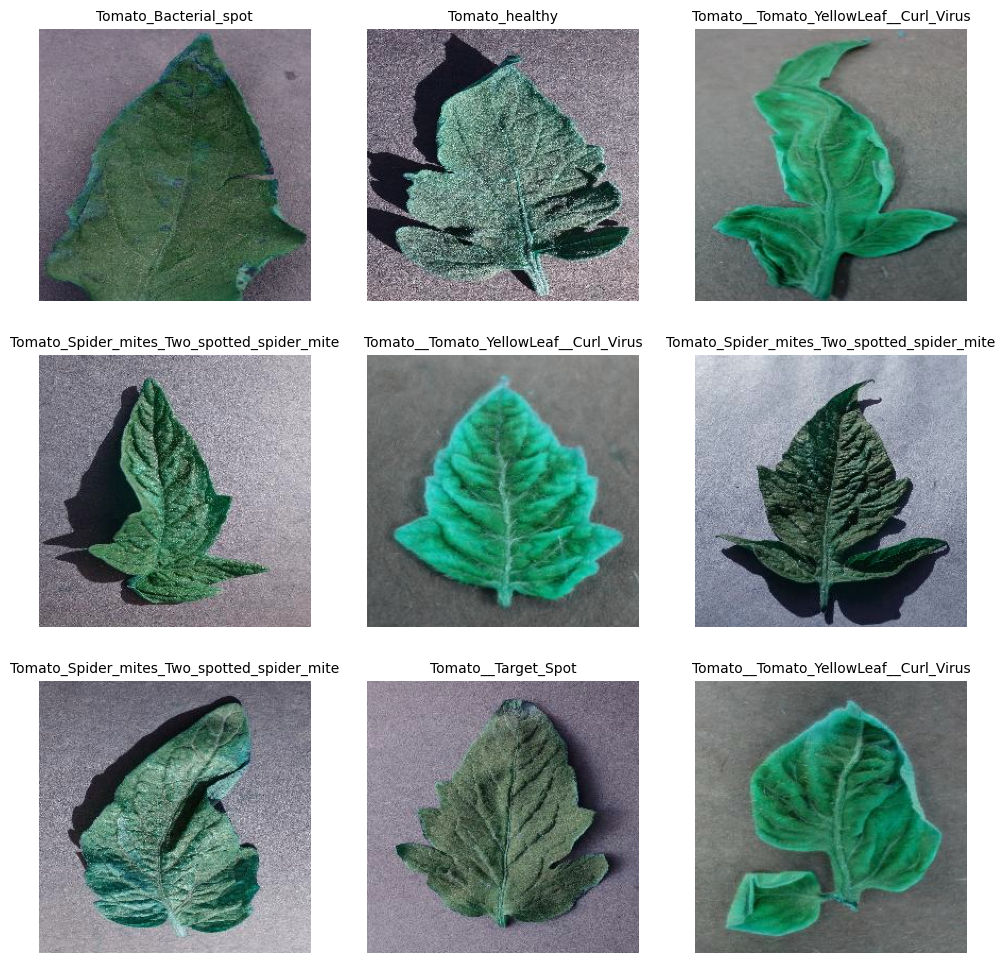

In [5]:
def display_random_images(rows,cols):
    fig, ax = plt.subplots(rows,cols,figsize=(12,12))
    random = train.sample(rows*cols)

    for i in range(rows):
        for j in range(cols):
            row_data = random.iloc[i * cols + j]
            image_path = os.path.join(data_dir, row_data['File'])
            disease_type = row_data['Disease_Type']
            ax[i,j].imshow(cv2.imread(image_path))
            ax[i,j].axis('off')
            ax[i, j].set_title(disease_type, fontsize=10)

display_random_images(3,3)

In [6]:
def get_training_data():
    data = np.zeros((train.shape[0],IMAGE_SIZE,IMAGE_SIZE,COLORS))
    for i, file in tqdm(enumerate(train['File'].values)):
        img = cv2.imread(os.path.join(data_dir,file))
        if img is not None:
            img_resized = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE),interpolation=cv2.INTER_AREA)
            img_resized = img_resized/255
            data[i]=img_resized
    return data

X = get_training_data()

20639it [06:00, 57.21it/s]


In [7]:
X.shape

(20639, 80, 80, 3)

In [8]:
y = to_categorical(train['DiseaseID'],num_classes=np.unique(train['DiseaseID']).size)
print(y.shape)

(20639, 15)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE)

In [10]:
NUM_CLASSES = int(np.unique(train['DiseaseID']).size)

In [11]:
print(f'x train shape is {X_train.shape}')
print(f'x val shape is {X_val.shape}')
print(f'y train shape is {y_train.shape}')
print(f'y val shape is {y_val.shape}')

x train shape is (16511, 80, 80, 3)
x val shape is (4128, 80, 80, 3)
y train shape is (16511, 15)
y val shape is (4128, 15)


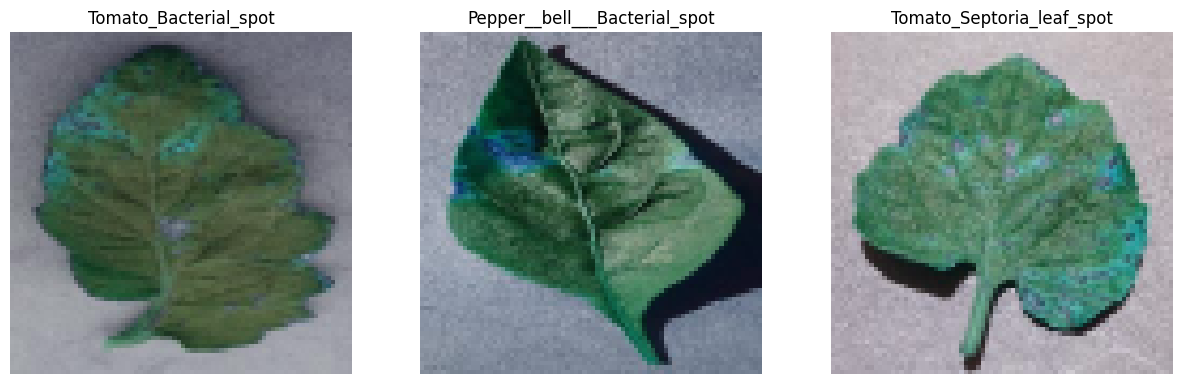

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(classification_types[np.argmax(y_train[i])])

In [13]:
base_model=Xception(weights='imagenet',include_top=False,pooling='avg',
                    input_shape=INPUT_SHAPE)
base_model.trainable=False
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Dropout(0.45))
model.add(Dense(220,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(60,activation='relu'))
model.add(Dense(NUM_CLASSES,activation='softmax',name='root'))

optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

C:\Users\Usama Mohiuddin\AppData\Roaming\Python\Python311\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ root (Dense)                    │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train,y_train,
                        epochs= 10,
                        validation_data = (X_val,y_val),
                        callbacks = early_stopping)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 396s 742ms/step - accuracy: 0.2246 - loss: 2.7748 - val_accuracy: 0.6306 - val_loss: 1.1889
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 378s 734ms/step - accuracy: 0.5404 - loss: 1.4224 - val_accuracy: 0.7035 - val_loss: 0.9006
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 377s 730ms/step - accuracy: 0.6231 - loss: 1.1526 - val_accuracy: 0.7422 - val_loss: 0.7783
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 383s 732ms/step - accuracy: 0.6591 - loss: 1.0419 - val_accuracy: 0.7544 - val_loss: 0.7259
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 379s 734ms/step - accuracy: 0.6815 - loss: 0.9614 - val_accuracy: 0.7728 - val_loss: 0.6910
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 564s 1s/step - accuracy: 0.6985 - loss: 0.9047 - val_accuracy: 0.7766 - val_loss: 0.6638
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 525s 906ms/step - accuracy: 0.7120 - loss: 0.8720 - val_accuracy: 0.7917 - val_loss: 0.6315
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 377s 732ms/step - accuracy: 0.7201 - lo

C:\Users\Usama Mohiuddin\AppData\Local\Temp\ipykernel_19508\1479236627.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


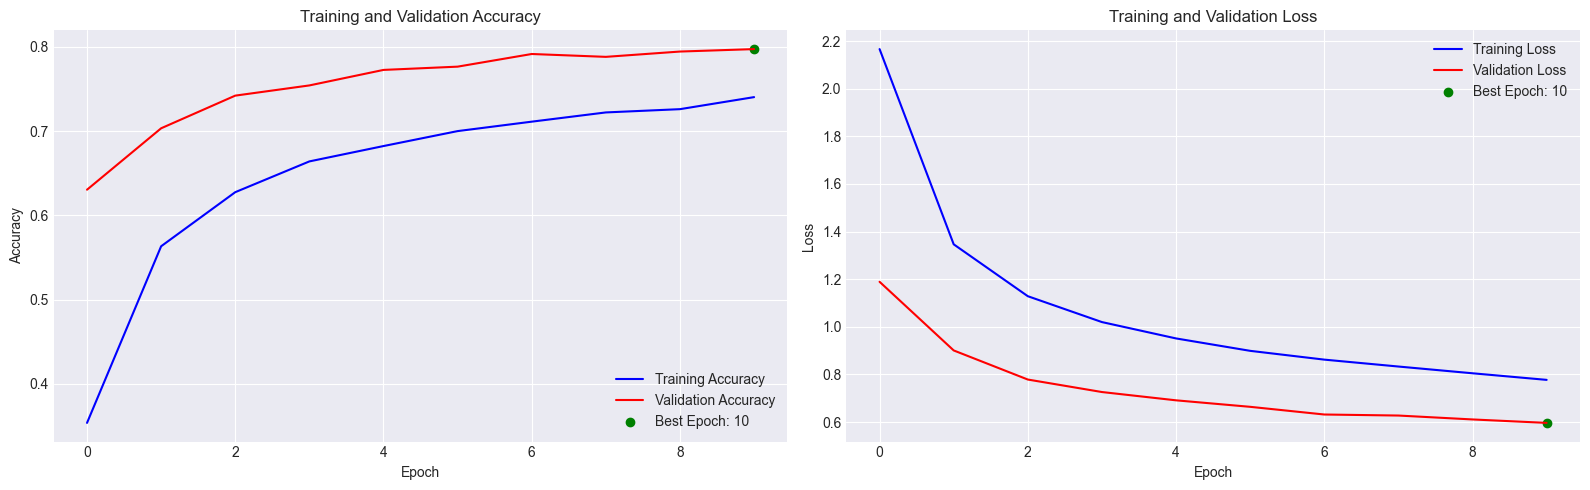

In [15]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [16]:
print(f"accuracy is : {round(history.history['accuracy'][best_epoch-1],2)}")
print(f"val accuracy is: {round(history.history['val_accuracy'][best_epoch-1],2)}")

accuracy is : 0.74
val accuracy is: 0.8


In [17]:
def yolo_v8_classification(input_shape, num_classes):
    """
    Builds a YOLOv8-like model for multi-class classification.

    Args:
        input_shape (tuple): Shape of the input images (H, W, C).
        num_classes (int): Number of output classes.

    Returns:
        model (tf.keras.Model): YOLOv8-like classification model.
    """
    inputs = Input(shape=input_shape)

    # Backbone (Feature Extraction)
    x = Conv2D(32, (3, 3), strides=1, padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # Spatial Pyramid Pooling (SPP) Block
    spp1 = MaxPooling2D(pool_size=5, strides=1, padding="same")(x)
    spp2 = MaxPooling2D(pool_size=9, strides=1, padding="same")(x)
    spp3 = MaxPooling2D(pool_size=13, strides=1, padding="same")(x)
    x = Concatenate()([x, spp1, spp2, spp3])

    # Classification Head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(220, activation="relu")(x)  # Fully connected layer
    x = Dropout(0.5)(x)
    x = Dense(60, activation="relu")(x)  # Fully connected layer
    outputs = Dense(num_classes, activation="softmax", name="root")(x)  # Output layer

    # Model
    model = Model(inputs, outputs, name="YOLOv8_Like_Classification")
    return model

model = yolo_v8_classification(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "YOLOv8_Like_Classification"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 80, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 80, 80,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 40, 40,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 20, 20,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (Concatenate)       │ 512)              │            │ max_pooling2d[0]… │
│                     │                   │            │ max_pooling2d_1[… │
│                     │                   │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ concatenate[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 220)       │    112,860 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 220)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 60)        │     13,260 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 223,227 (871.98 KB)

 Trainable params: 221,755 (866.23 KB)

 Non-trainable params: 1,472 (5.75 KB)

In [18]:
optimizer = Adam(learning_rate=0.0005)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train,y_train,
                        epochs= 5,
                        validation_data = (X_val,y_val),
                   callbacks=early_stopping)

Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 278s 524ms/step - accuracy: 0.3660 - loss: 2.1531 - val_accuracy: 0.1870 - val_loss: 5.3376
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 271s 526ms/step - accuracy: 0.6796 - loss: 0.9639 - val_accuracy: 0.6257 - val_loss: 1.1871
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 325s 531ms/step - accuracy: 0.7673 - loss: 0.6889 - val_accuracy: 0.6688 - val_loss: 0.9385
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 271s 525ms/step - accuracy: 0.8083 - loss: 0.5706 - val_accuracy: 0.8626 - val_loss: 0.3814
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 275s 533ms/step - accuracy: 0.8434 - loss: 0.4753 - val_accuracy: 0.8924 - val_loss: 0.3223


C:\Users\Usama Mohiuddin\AppData\Local\Temp\ipykernel_19508\1479236627.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


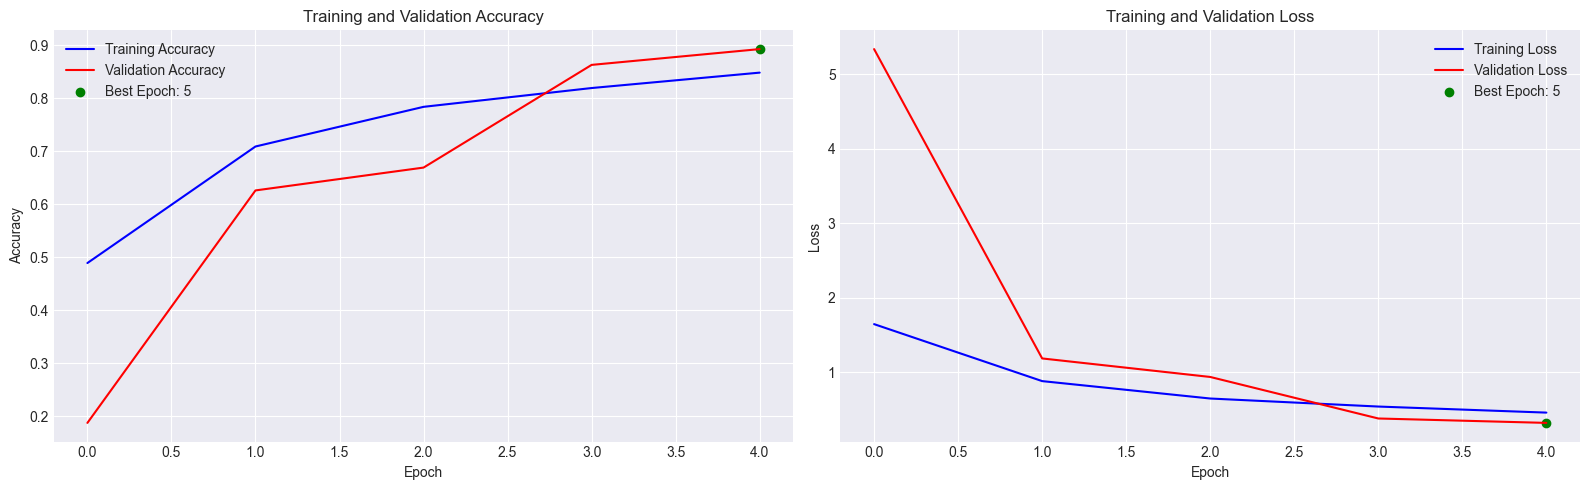

In [20]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [21]:
print(f"accuracy is : {round(history.history['accuracy'][best_epoch-1],2)}")
print(f"val accuracy is: {round(history.history['val_accuracy'][best_epoch-1],2)}")

accuracy is : 0.85
val accuracy is: 0.89
